In [1]:
from scipy.ndimage.filters import convolve 
import numpy as np
import scipy.linalg as LA 
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import rotate
import cv2
from skimage.util import random_noise
from skimage.transform import rescale
from skimage.filters import  gaussian

In [51]:
path='/content/drive/MyDrive/AIP/Assignment-1/'
i1='test_data/Albatross_test/Black_Footed_Albatross_0058_796074.jpg'
i2='bean.png'
#file name variable
def Q1(i):
  r=plt.imread(path+i)
  rg=convolve(rgb2gray(r), gaussian_filter(1.3))
  rpyramid=generate_gaussian_pyramid(rg,2,4,1.6)
  DoG_pyramid = generate_DoG_pyramid(rpyramid) 
  points=get_candidate_keypoints(np.array(DoG_pyramid[0]))
  color = (255,255,0)
  temp=np.copy(r)
  for i in points:
    c=(int(i[1]),int(i[0]))
    cv2.circle(temp,c,3,color=color)
  plt.imshow(temp)
  return temp

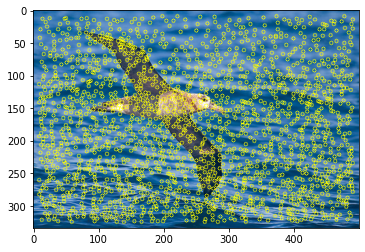

In [54]:
temp=Q1(i1)
plt.imshow(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  import sys
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


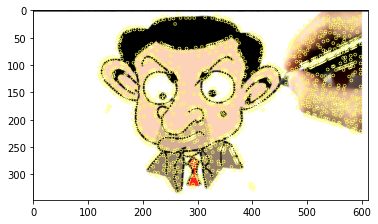

In [52]:
temp=Q1(i2)
plt.imshow(temp)

In [55]:
def gaussian_filter(sigma): 
  size = 2*np.ceil(3*sigma)+1 
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1] 
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  return g/g.sum()

def generate_octave(init_level, s, sigma): 
  octave = [init_level] 
  k = 2**(1/s) 
  kernel = gaussian_filter(k * sigma) 
  for _ in range(s+2): 
    next_level = convolve(octave[-1], kernel) 
    octave.append(next_level) 
  return octave


def generate_gaussian_pyramid(im, num_octave, s, sigma): 
  pyr = [] 
  for _ in range(num_octave): 
    octave = generate_octave(im, s, sigma) 
    pyr.append(octave) 
    im = octave[-3][::2, ::2] 
  return pyr


def generate_DoG_octave(gaussian_octave): 
  octave = [] 
  for i in range(1, len(gaussian_octave)):   
    octave.append(gaussian_octave[i] - gaussian_octave[i-1])

  return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2) 

def generate_DoG_pyramid(gaussian_pyramid): 
  pyr = [] 
  for gaussian_octave in gaussian_pyramid: 
    pyr.append(generate_DoG_octave(gaussian_octave)) 
  return pyr

def get_candidate_keypoints(D, w=16): 
  candidates = [] 
  D[:,:,0] = 0 
  D[:,:,-1] = 0 
  # D[:,:,0] = 0 
  # D[:,:,-1] = 0 
  for i in range(w//2+1, D.shape[0]-w//2 - 1): 
    for j in range(w//2+1, D.shape[1]-w//2-1): 
      for k in range(1, D.shape[2]-1): 
        patch = D[i-1:i+2, j-1:j+2, k-1:k+2] 
        if np.argmax(patch) == 13 or np.argmin(patch) == 13: 
          candidates.append([i, j, k]) 
  return candidates

def localize_keypoint(D, x, y, s): 
  dx = (D[y,x+1,s]-D[y,x-1,s])/2. 
  dy = (D[y+1,x,s]-D[y-1,x,s])/2. 
  ds = (D[y,x,s+1]-D[y,x,s-1])/2. 
  dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s] 
  dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4. 
  dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4. 
  dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s] 
  dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4. 
  dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1] 
  J = np.array([dx, dy, ds]) 
  HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]]) 
  offset = -LA.inv(HD).dot(J)
  return offset, J, HD[:2,:2], x, y, s

def find_keypoints_for_DoG_octave(D, R_th, t_c, w): 
  candidates = get_candidate_keypoints(D, w)
  keypoints = [] 
  for i, cand in enumerate(candidates): 
    y, x, s = cand[0], cand[1], cand[2] 
    offset, J, H, x, y, s = localize_keypoint(D, x, y, s) 
    contrast = D[y,x,s] + .5*J.dot(offset) 
    if abs(contrast) < t_c: continue 
    w, v = LA.eig(H) 
    r = w[1]/w[0] 
    R = (r+1)**2 / r 
    if R > R_th: continue 
    kp = np.array([x, y, s]) + offset
    keypoints.append(kp)
  return np.array(keypoints)

def get_keypoints(DoG_pyr, R_th, t_c, w): 
  kps = [] 
  for D in DoG_pyr: 
    kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w)) 
  return kps

In [56]:
class SIFT(object): 
  def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16): 
    self.im = convolve(rgb2gray(im), gaussian_filter(s0)) 
    self.s = s 
    self.sigma = sigma 
    self.num_octave = num_octave
    self.t_c = t_c 
    self.R_th = (r_th+1)**2 / r_th 
    self.w = w 
  def get_features(self): 
    gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma) 
    DoG_pyr = generate_DoG_pyramid(gaussian_pyr) 
    kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w) 
    
    return kp_pyr



In [61]:
from matplotlib.figure import figaspect
path='/content/drive/MyDrive/AIP/Assignment-1/'
i1='test_data/Albatross_test/Black_Footed_Albatross_0058_796074.jpg'
i2='iisc.jpg'
i3='bean.png'
img=plt.imread(path+i3)
img1=plt.imread(path+i1)
def Peak_detection(img,name):
  #if 'p' not in locals():
  p=SIFT(img)
  data=p.get_features()

  color = (255,255,0)
  temp=np.copy(img)
  for i in data[0]:
    c=(int(i[0]),int(i[1]))
    cv2.circle(temp,c,7,color=color)
  rotate=rotate_image(img)
  noisy=noise_image(img)
  blur=blur_image(img)
  scale=scale_image(img,2)
  # f = plt.figure(figsize=(30,30))
  # ax = f.add_subplot(131)
  # ax2 = f.add_subplot(132)
  # ax.imshow(img)
  # ax.set(title='Original')
  # ax2.imshow(temp)
  # ax2.set(title='Extrema detection scratch SIFT')
  # f.savefig('/content/drive/MyDrive/AIP/Assignment-1/'+name)
  plt.figure(figsize=(15,15))

  plt.subplot(231)
  plt.title('Original')
  plt.imshow(img)

  plt.subplot(232)
  plt.title('Extrema detection scratch SIFT')
  plt.imshow(temp)

  plt.subplot(233)
  plt.title('rotate')
  plt.imshow(rotate)

  plt.subplot(234)
  plt.title('noisy')
  plt.imshow(noisy)

  plt.subplot(235)
  plt.title('blur')
  plt.imshow(blur)

  plt.subplot(236)
  plt.title('scale')
  plt.imshow(scale)

  plt.savefig('/content/drive/MyDrive/AIP/Assignment-1/'+name)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

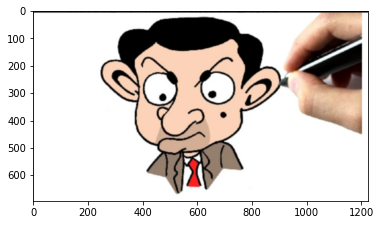

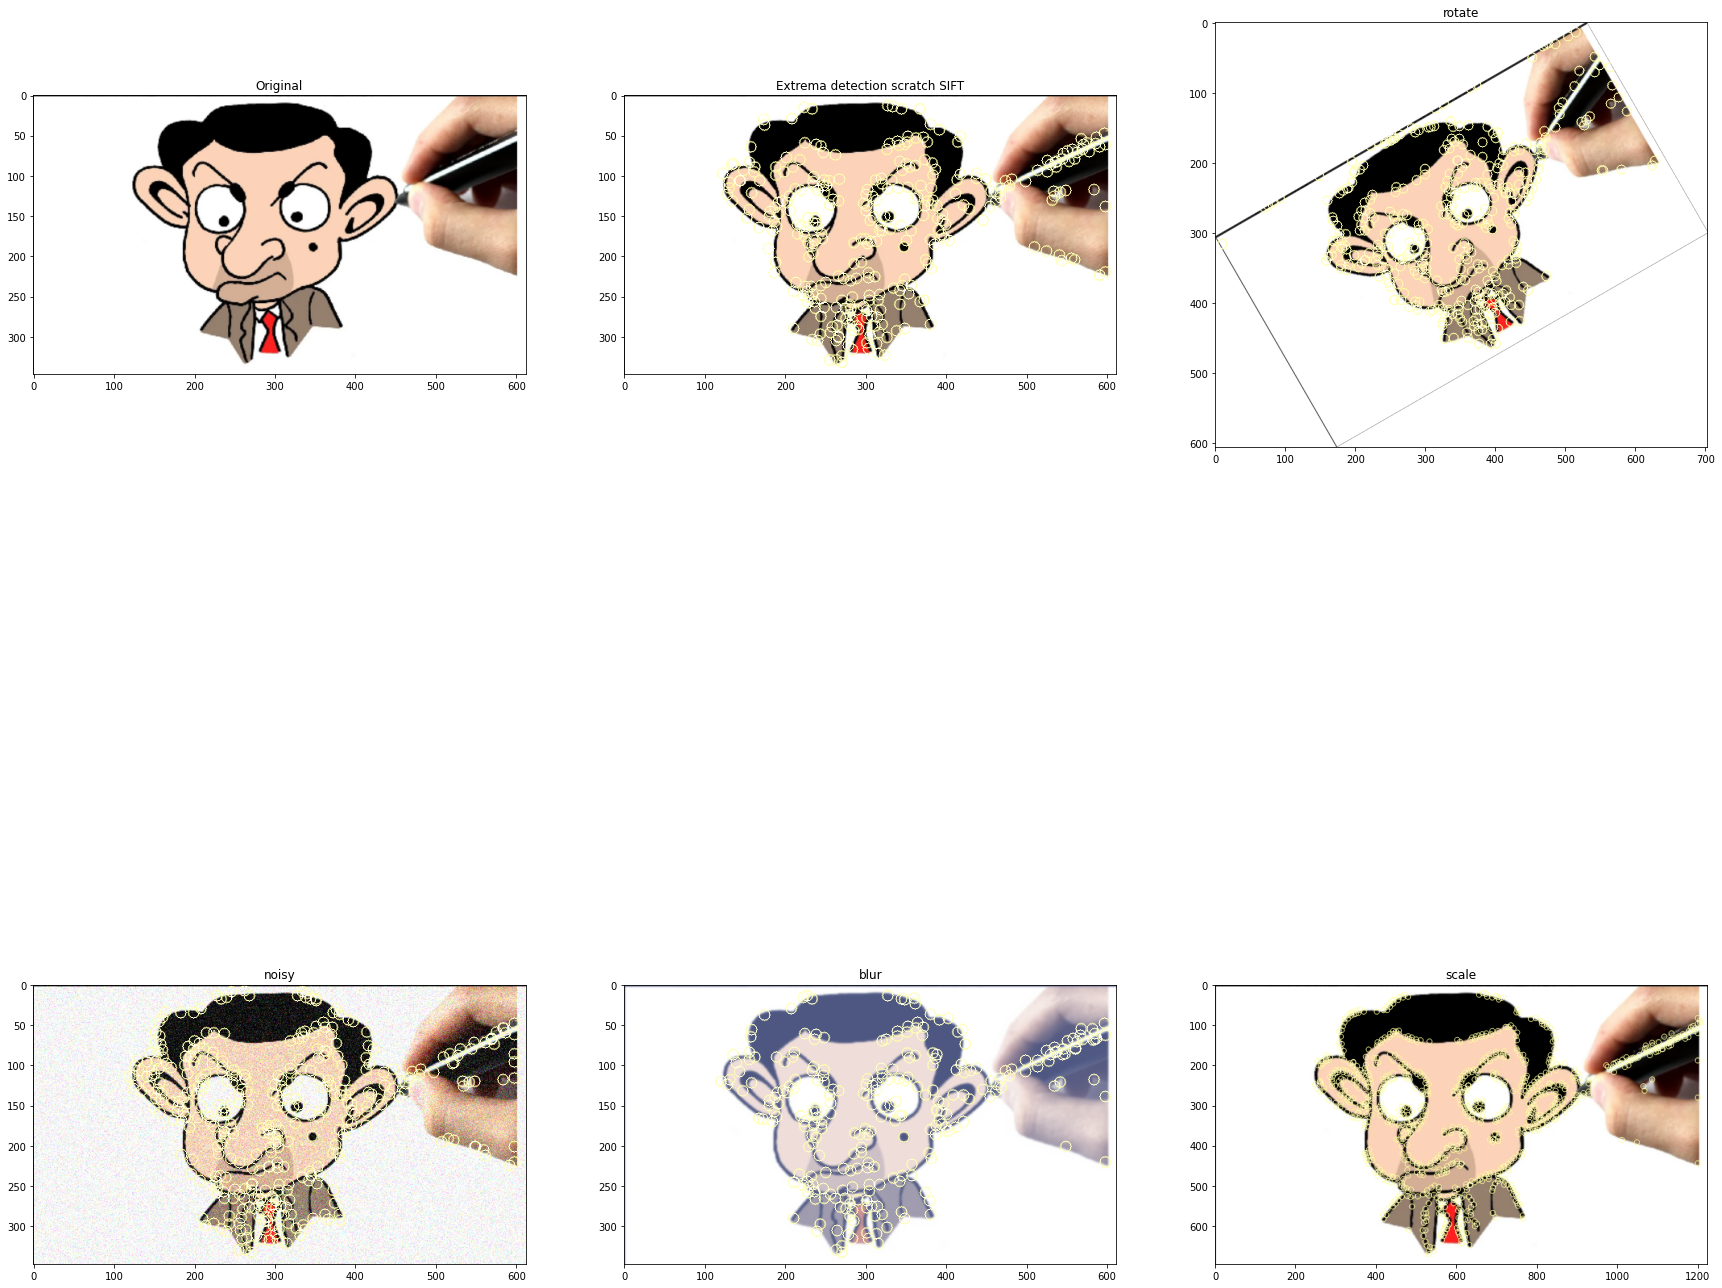

In [63]:
Peak_detection(img,name='bean_SIFT.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


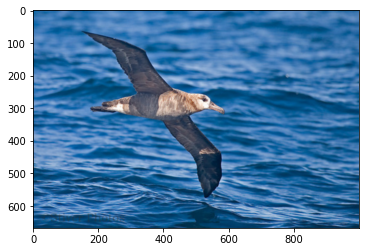

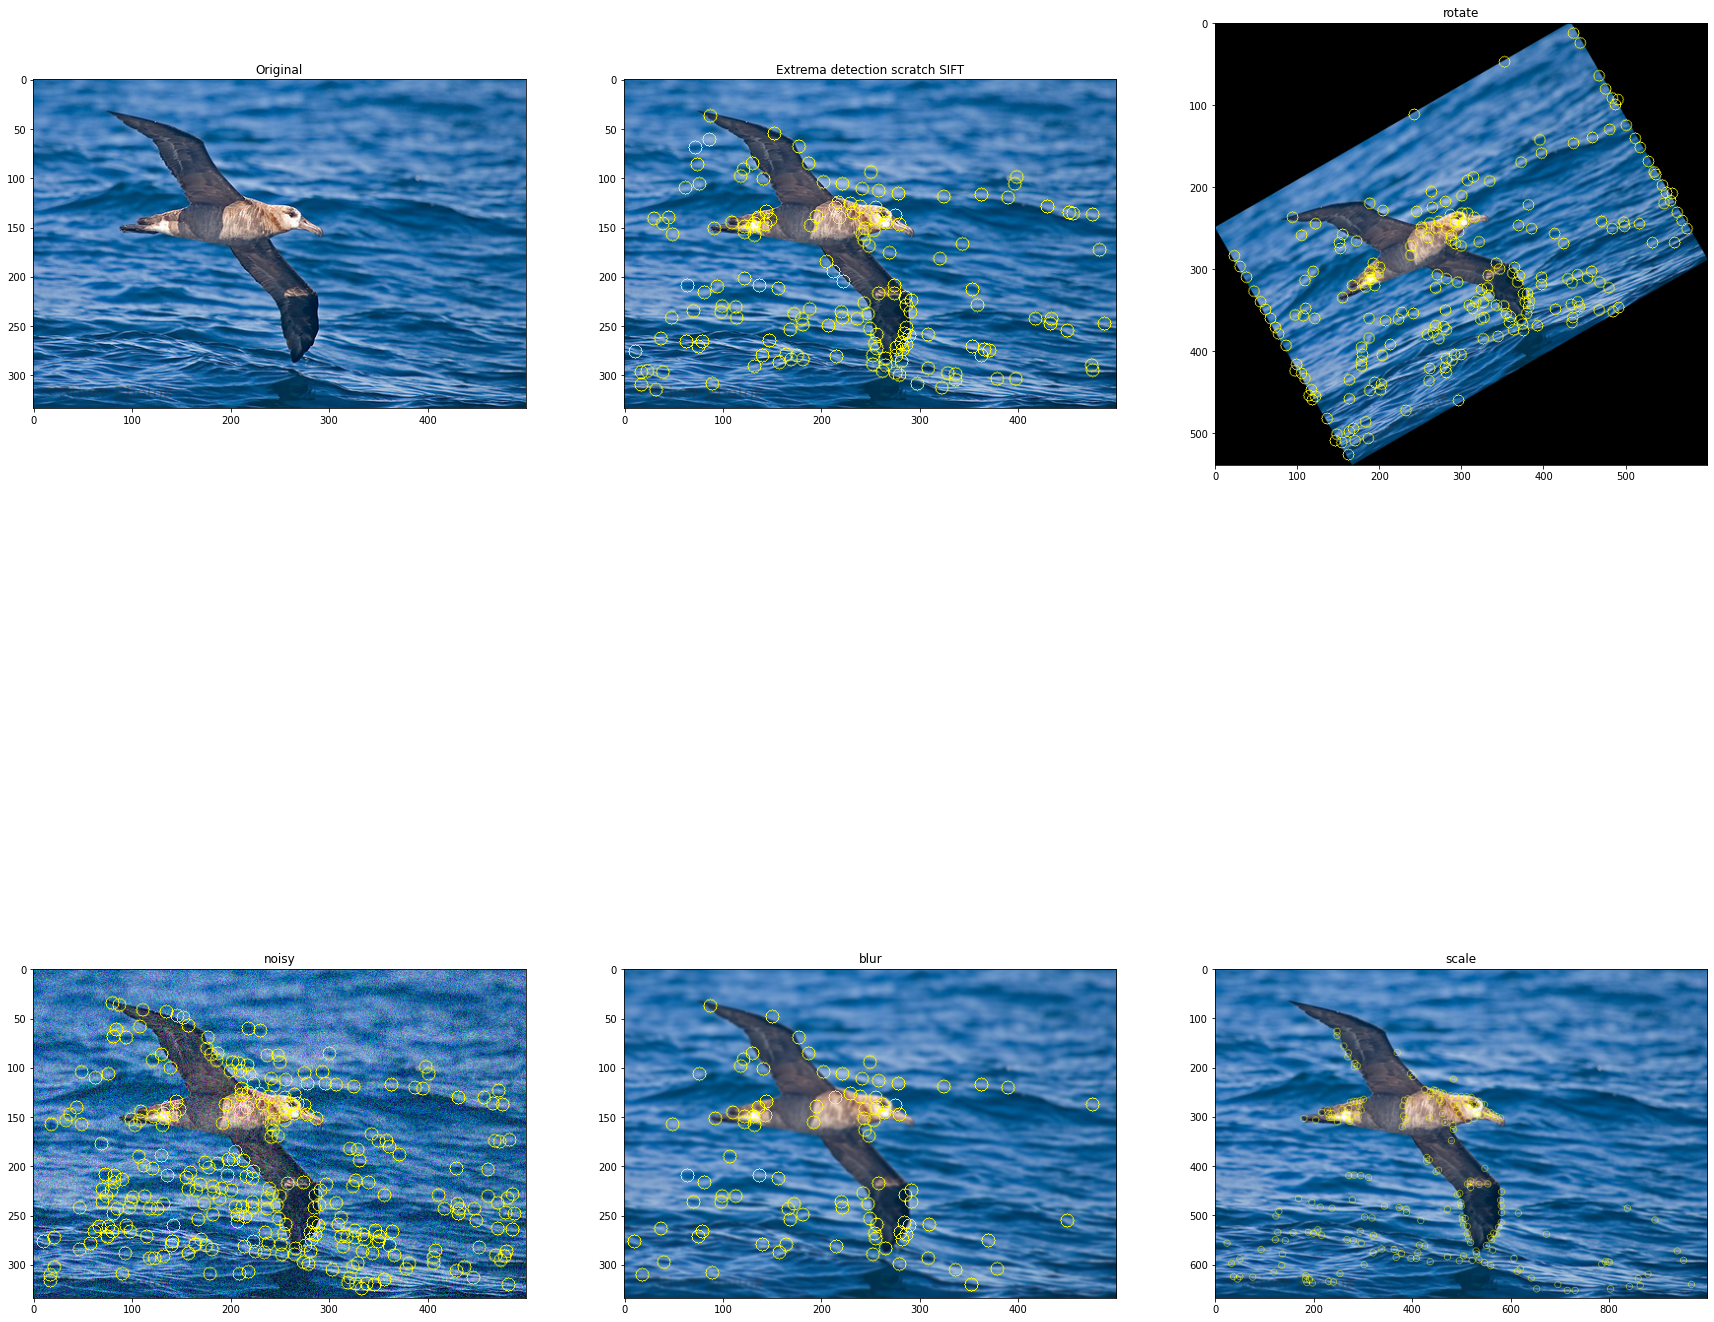

In [64]:
Peak_detection(img1,name='Albatross_SIFT.png')

Rotate image

In [57]:
def rotate_image(img):
  img_30=rotate(img,30,resize='False')
  plt.imshow(img_30)

  p=SIFT(img_30)
  data_30=p.get_features()

  temp=np.copy(img_30)
  for i in data_30[0]:
    c=(int(i[0]),int(i[1]))
    cv2.circle(temp,c,7,color)
  #plt.imshow(temp,cmap='gray')
  return temp

Noisy image

In [58]:
def noise_image(img):
  noisy_img=random_noise(img, mode='gaussian', seed=None, clip=True)
  plt.imshow(noisy_img)

  p=SIFT(noisy_img)
  data_noisy=p.get_features()

  temp=np.copy(noisy_img)
  for i in data_noisy[0]:
    c=(int(i[0]),int(i[1]))
    cv2.circle(temp,c,7,color)
  # plt.imshow(temp,cmap='gray')
  return temp

Rescale

In [59]:
def scale_image(img,f):
  img_rescaled = rescale(img, [f,f,1], anti_aliasing=False)
  plt.imshow(img_rescaled)

  p=SIFT(img_rescaled)
  data_scale=p.get_features()

  temp=np.copy(img_rescaled)
  for i in data_scale[0]:
    c=(int(i[0]),int(i[1]))
    cv2.circle(temp,c,7,color)
  #plt.imshow(temp,cmap='gray')
  return temp

Blury image

In [60]:
def blur_image(img):
  img_blur=gaussian(img, sigma=1)
  plt.imshow(img_blur)

  p=SIFT(img_blur)
  data_blur=p.get_features()

  temp=np.copy(img_blur)
  for i in data_blur[0]:
    c=(int(i[0]),int(i[1]))
    cv2.circle(temp,c,7,color)
  plt.imshow(temp,cmap='gray')
  return temp